In [213]:
import numpy as np
import pandas as pd
import folium
import matplotlib.pyplot as plt

In [163]:
country_geo = 'datasets/all_countries.geo.json'

In [352]:
covid_data = pd.read_csv('datasets/COVID-19-worldwide.csv')
pop_dens = pd.read_csv('datasets/population_density.csv')
tourism_data = pd.read_csv('datasets/tourism_data.csv')

In [488]:
sqmt = pd.read_csv('datasets/squaremeter_per_country.csv')
urban_area = pd.read_csv('datasets/urban_landarea.csv')
urban_pop = pd.read_csv('datasets/urban_pop.csv')
rural_pop = pd.read_csv('datasets/rural_pop.csv')

In [493]:
rural_2018 = rural_pop[['Country Name','Country Code','2018']]
rural_2018.set_index('Country Code',inplace=True)
rural_2018 = rural_2018.drop(index=['SSF','WLD','HIC','OED','PST','ECS','IBT','LMY','EUU','MIC','IBD','EMU','UMC','LTE','EAS','EAR','TEC','EAP','TEA','ECA','LMC','LCN','MEA','ARB','NAC','TLA','CEB','LAC','MNA','TMN','SST','OSS','LDC','TSA','SAS','TSS','SSA','FCS','HPC','PRE'])

In [434]:
urban_pop.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,Unnamed: 64
0,Aruba,ABW,Urban population,SP.URB.TOTL,27526.0,28141.0,28532.0,28761.0,28924.0,29082.0,...,43819.0,44057.0,44348.0,44665.0,44979.0,45296.0,45616.0,45948.0,NaN,NaN
1,Afghanistan,AFG,Urban population,SP.URB.TOTL,755836.0,796272.0,839385.0,885228.0,934135.0,986074.0,...,7212518.0,7528588.0,7865067.0,8204877.0,8535606.0,8852859.0,9164841.0,9477100.0,NaN,NaN
2,Angola,AGO,Urban population,SP.URB.TOTL,569222.0,597288.0,628381.0,660180.0,691532.0,721552.0,...,14660282.0,15383127.0,16130304.0,16900847.0,17691524.0,18502165.0,19332881.0,20184707.0,NaN,NaN
3,Albania,ALB,Urban population,SP.URB.TOTL,493982.0,513592.0,530766.0,547928.0,565248.0,582374.0,...,1546929.0,1575788.0,1603505.0,1630119.0,1654503.0,1680247.0,1706345.0,1728969.0,NaN,NaN
4,Andorra,AND,Urban population,SP.URB.TOTL,7839.0,8766.0,9754.0,10811.0,11915.0,13067.0,...,74305.0,73056.0,71515.0,70057.0,68919.0,68213.0,67876.0,67813.0,NaN,NaN


In [463]:
urban_2018 = urban_pop[['Country Name','Country Code','2018']]

In [464]:
urban_2018.set_index('Country Code',inplace=True)
urban_2018 = urban_2018.drop(index=['SSF','WLD','HIC','OED','PST','ECS','IBT','LMY','EUU','MIC','IBD','EMU','UMC','LTE','EAS','EAR','TEC','EAP','TEA','ECA','LMC','LCN','MEA','ARB','NAC','TLA','CEB','LAC','MNA','TMN','SST','OSS','LDC','TSA','SAS','TSS','SSA','FCS','HPC','PRE'])

KeyError: "['GGY'] not found in axis"

In [460]:
urban_2018.sort_values('2018',ascending=False)

,Country Name,2018
Country Code,,
CHN,China,823827650.0
IDA,IDA total,607055094.0
IND,India,460295677.0
IDX,IDA only,371491722.0
USA,United States,268720071.0
IDB,IDA blend,235563372.0
LIC,Low income,229769967.0
BRA,Brazil,181335507.0
IDN,Indonesia,148084795.0


In [425]:
sqmt = sqmt[['Country Name','Country Code','2017','2018']]


In [315]:
pop_dens.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,Unnamed: 64
0,Aruba,ABW,Population density (people per sq. km of land ...,EN.POP.DNST,NaN,307.988889,312.361111,314.972222,316.844444,318.666667,...,566.922222,569.777778,573.105556,576.522222,579.672222,582.622222,585.366667,588.027778,NaN,NaN
1,Afghanistan,AFG,Population density (people per sq. km of land ...,EN.POP.DNST,NaN,14.044987,14.323808,14.617537,14.926295,15.250314,...,46.131503,47.730564,49.428038,51.114778,52.712072,54.197114,55.595993,56.937760,NaN,NaN
2,Angola,AGO,Population density (people per sq. km of land ...,EN.POP.DNST,NaN,4.436891,4.498708,4.555593,4.600180,4.628676,...,19.427818,20.139513,20.867715,21.610475,22.366552,23.135064,23.916538,24.713052,NaN,NaN
3,Albania,ALB,Population density (people per sq. km of land ...,EN.POP.DNST,NaN,60.576642,62.456898,64.329234,66.209307,68.058066,...,106.029015,105.854051,105.660292,105.441752,105.135146,104.967190,104.870693,104.612263,NaN,NaN
4,Andorra,AND,Population density (people per sq. km of land ...,EN.POP.DNST,NaN,30.585106,32.702128,34.919149,37.168085,39.465957,...,178.185106,175.376596,171.859574,168.538298,165.980851,164.461702,163.831915,163.842553,NaN,NaN


In [319]:
pop_dens_cleaner = pop_dens[['Country Name','Country Code','2018']]

In [322]:
pop_dens_cleanest = pop_dens_cleaner.set_index('Country Code')

In [326]:
print(pop_dens_cleanest)

                                                   Country Name         2018
Country Code                                                                
ABW                                                       Aruba   588.027778
AFG                                                 Afghanistan    56.937760
AGO                                                      Angola    24.713052
ALB                                                     Albania   104.612263
AND                                                     Andorra   163.842553
ARB                                                  Arab World    37.372365
ARE                                        United Arab Emirates   135.609110
ARG                                                   Argentina    16.258510
ARM                                                     Armenia   103.680225
ASM                                              American Samoa   277.325000
ATG                                         Antigua and Barbuda   218.831818

In [165]:
t = covid_data.groupby('countryterritoryCode').count()

In [494]:
new_df = covid_data
new_df = new_df.set_index('countryterritoryCode')
new_df['total_deaths'] = 0
new_df['total_cases'] = 0
new_df['deaths_per_100k'] = 0
new_df['cases_per_100k'] = 0
new_df['current_infection_rate'] = 0
new_df['tourists_per_100k'] = 0
new_df['urban_pop_per_100k'] = 0
new_df['rural_percent'] = 0

new_df = new_df[::-1]

for idx, row in t.iterrows():
    new_df.loc[[idx],['total_deaths']] = new_df.loc[idx]['deaths'].cumsum(axis=0)
    new_df.loc[[idx],['total_cases']] = new_df.loc[idx]['cases'].cumsum(axis=0)
    
    new_df.loc[[idx],['deaths_per_100k']] = (100000 * (new_df.loc[idx]['total_deaths'] / new_df.loc[idx]['popData2018'])).round(3)
    new_df.loc[[idx],['cases_per_100k']] = (100000 * (new_df.loc[idx]['total_cases'] / new_df.loc[idx]['popData2018'])).round(3)
    
    if(idx in urban_2018.index):
        new_df.loc[[idx],['urban_pop_per_100k']] = (100000 * (urban_2018.loc[idx]['2018'] / new_df.loc[idx]['popData2018'])).round(3)
        
    if(idx in rural_2018.index):
        new_df.loc[[idx],['rural_percent']] = rural_2018.loc[idx]['2018']

    


In [495]:
for i in range(2,len(new_df)):
    current_country = new_df.iloc[i].name
    previous_country = new_df.iloc[i-1].name
    if(current_country == previous_country):
        previous_cases = new_df.iloc[i-1,new_df.columns.get_loc('cases')]
        current_cases = new_df.iloc[i,new_df.columns.get_loc('cases')]
        #Avoiding zero-division
        if(previous_cases > 0 and current_cases > 0):
            new_df.iloc[i,new_df.columns.get_loc('current_infection_rate')] = (current_cases / previous_cases).round(1)

In [496]:
new_df = new_df[::-1]

In [497]:
new_df.loc['USA'].head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,popData2018,continentExp,total_deaths,total_cases,deaths_per_100k,cases_per_100k,current_infection_rate,tourists_per_100k,urban_pop_per_100k,rural_percent
countryterritoryCode,,,,,,,,,,,,,,,,,,
USA,4/27/2020,27,4,2020,26857,1687,United_States_of_America,US,327167434.0,America,54876,965910,16.773,295.234,0.6,0,82135.336,17.744
USA,4/26/2020,26,4,2020,48529,2172,United_States_of_America,US,327167434.0,America,53189,939053,16.257,287.025,2.3,0,82135.336,17.744
USA,4/25/2020,25,4,2020,21352,1054,United_States_of_America,US,327167434.0,America,51017,890524,15.594,272.192,0.8,0,82135.336,17.744
USA,4/24/2020,24,4,2020,26543,3179,United_States_of_America,US,327167434.0,America,49963,869172,15.271,265.666,1.5,0,82135.336,17.744
USA,4/23/2020,23,4,2020,17588,1721,United_States_of_America,US,327167434.0,America,46784,842629,14.300,257.553,0.5,0,82135.336,17.744


In [481]:
new_df[new_df['dateRep'] == '4/27/2020'].sort_values('urban_pop_per_100k',ascending=False)[:20]

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,popData2018,continentExp,total_deaths,total_cases,deaths_per_100k,cases_per_100k,current_infection_rate,tourists_per_100k,urban_pop_per_100k
countryterritoryCode,,,,,,,,,,,,,,,,,
TCA,4/27/2020,27,4,2020,0,0,Turks_and_Caicos_islands,TC,31458.0,America,1,11,3.179,34.967,0.000,0,111466.082
BMU,4/27/2020,27,4,2020,10,0,Bermuda,BM,63968.0,America,5,109,7.816,170.398,0.000,0,100007.816
MCO,4/27/2020,27,4,2020,0,0,Monaco,MC,38682.0,Europe,4,94,10.341,243.007,0.000,0,100000.000
KWT,4/27/2020,27,4,2020,183,1,Kuwait,KW,4137309.0,Asia,20,3075,0.483,74.324,0.658,0,100000.000
CYM,4/27/2020,27,4,2020,0,0,Cayman_Islands,KY,64174.0,America,1,70,1.558,109.078,0.000,0,100000.000
GIB,4/27/2020,27,4,2020,5,0,Gibraltar,GI,33718.0,Europe,4,141,11.863,418.174,1.667,0,100000.000
SGP,4/27/2020,27,4,2020,931,0,Singapore,SG,5638676.0,Asia,12,13624,0.213,241.617,0.615,0,100000.000
QAT,4/27/2020,27,4,2020,929,0,Qatar,QA,2781677.0,Asia,10,10287,0.359,369.813,1.115,0,99134.982
BEL,4/27/2020,27,4,2020,809,177,Belgium,BE,11422068.0,Europe,7094,46134,62.108,403.902,0.784,0,98096.991


In [226]:
present_day_df = new_df[new_df['dateRep'] == '4/27/2020']

In [209]:
present_day_df.loc['USA']

dateRep                                   4/27/2020
day                                              27
month                                             4
year                                           2020
cases                                         26857
deaths                                         1687
countriesAndTerritories    United_States_of_America
geoId                                            US
popData2018                             3.27167e+08
continentExp                                America
total_deaths                                  54876
total_cases                                  965910
deaths_per_100k                             16.7731
cases_per_100k                              295.234
Name: USA, dtype: object

In [305]:
bins = list(present_day_df['deaths_per_100k'].quantile([0,0.1,0.2,0.3,0.4,0.6,0.7,0.8,0.9,1]))
#bins = [0,0.5,1,3,4,5,20,40,90,130]

In [306]:
m = folium.Map(location=[48, -102], zoom_start=3)
folium.Choropleth(
    geo_data=country_geo,
    name='choropleth',
    data=present_day_df,
    columns=[present_day_df.index,'deaths_per_100k'],
    key_on='properties.iso_a3',
    fill_color='OrRd',
    fill_opacity=0.5,
    line_opacity=0.2,
    legend_name='pop',
    bins=bins,
    reset=True
).add_to(m)

In [307]:
m

In [227]:
present_day_df_clean = present_day_df.dropna()

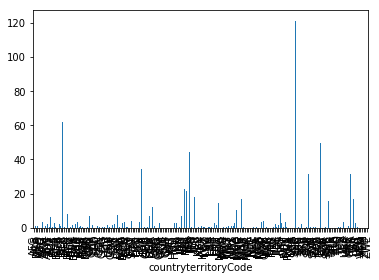

In [219]:
present_day_df_clean['deaths_per_100k'].plot(kind='bar')

In [235]:
present_day_df_clean = present_day_df_clean.sort_values(by=['deaths_per_100k'], ascending=False)[:20]

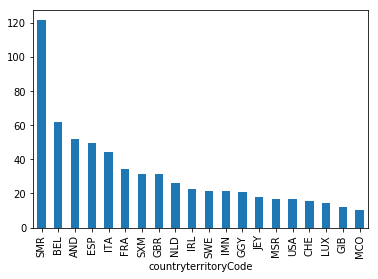

In [236]:
present_day_df_clean['deaths_per_100k'].plot(kind='bar')

In [334]:
bins = [0,10,50,100,200,300,500,1000,2000,21000]

In [335]:
m = folium.Map(location=[48, -102], zoom_start=3)
folium.Choropleth(
    geo_data=country_geo,
    name='choropleth',
    data=pop_dens_cleanest,
    columns=[pop_dens_cleanest.index,'2018'],
    key_on='properties.iso_a3',
    fill_color='OrRd',
    fill_opacity=0.5,
    line_opacity=0.2,
    legend_name='pop',
    bins=bins,
    reset=True
).add_to(m)

In [336]:
m

In [353]:
tourism_data.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,Unnamed: 64
0,Aruba,ABW,"International tourism, number of arrivals",ST.INT.ARVL,NaN,NaN,NaN,NaN,NaN,NaN,...,869000.0,904000.0,979000.0,1072000.0,1225000.0,1102000.0,1070500.0,1082000.0,NaN,NaN
1,Afghanistan,AFG,"International tourism, number of arrivals",ST.INT.ARVL,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Angola,AGO,"International tourism, number of arrivals",ST.INT.ARVL,NaN,NaN,NaN,NaN,NaN,NaN,...,481000.0,528000.0,650000.0,595000.0,592000.0,397000.0,261000.0,218000.0,NaN,NaN
3,Albania,ALB,"International tourism, number of arrivals",ST.INT.ARVL,NaN,NaN,NaN,NaN,NaN,NaN,...,2469000.0,3156000.0,2857000.0,3341000.0,3784000.0,4070000.0,4643000.0,5340000.0,NaN,NaN
4,Andorra,AND,"International tourism, number of arrivals",ST.INT.ARVL,NaN,NaN,NaN,NaN,NaN,NaN,...,2242000.0,2238000.0,2328000.0,2363000.0,2663000.0,2819000.0,3003000.0,3042000.0,NaN,NaN


In [498]:
t_data = tourism_data[['Country Name','Country Code', '2018']]

In [499]:
t_data.set_index('Country Code',inplace=True)

In [365]:
t_data.iloc[4].name

'AND'

In [392]:
bins = [2700,500000,1000000,15000000,30123000.0,45768000.0,79745920.0,89322000.0]

In [382]:
t_data.sort_values('2018',axis=0,ascending=False)

,Country Name,2018
Country Code,,
WLD,World,1.441953e+09
HIC,High income,8.666510e+08
OED,OECD members,7.873809e+08
PST,Post-demographic dividend,7.733657e+08
ECS,Europe & Central Asia,7.125925e+08
IBT,IDA & IBRD total,6.103049e+08
LMY,Low & middle income,5.690384e+08
EUU,European Union,5.558872e+08
MIC,Middle income,5.378847e+08


In [500]:
t_data = t_data.drop(index=['WLD','HIC','OED','PST','ECS','IBT','LMY','EUU','MIC','IBD','EMU','UMC','LTE','EAS','EAR','TEC','EAP','TEA','ECA','LMC','LCN','MEA','ARB','NAC','TLA','CEB','LAC','MNA','TMN','SST','OSS','LDC','TSA','SAS'])

In [391]:
t_data.sort_values('2018',axis=0,ascending=False)

,Country Name,2018
Country Code,,
FRA,France,89322000.0
ESP,Spain,82773000.0
USA,United States,79745920.0
CHN,China,62900000.0
ITA,Italy,61567200.0
TUR,Turkey,45768000.0
MEX,Mexico,41313000.0
DEU,Germany,38881000.0
THA,Thailand,38178000.0


In [393]:
m = folium.Map(location=[48, -102], zoom_start=3)
folium.Choropleth(
    geo_data=country_geo,
    name='choropleth',
    data=t_data,
    columns=[t_data.index,'2018'],
    key_on='properties.iso_a3',
    fill_color='OrRd',
    fill_opacity=0.5,
    line_opacity=0.2,
    legend_name='tourism',
    bins=bins,
    reset=True
).add_to(m)

In [501]:
for i in range(1,len(t_data)):
    country_code = t_data.iloc[i].name
    if (country_code in new_df.index):
        tourists_total = t_data.iloc[i,t_data.columns.get_loc('2018')]
        new_df.loc[[country_code],['tourists_per_100k']] = (tourists_total / new_df.loc[country_code]['popData2018']).round(3)

In [417]:
t_data.loc['MLI']

Country Name     Mali
2018            14000
Name: MLI, dtype: object

In [418]:
new_df.sort_values('tourists_per_100k',axis=0,ascending=False)

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,popData2018,continentExp,total_deaths,total_cases,deaths_per_100k,cases_per_100k,current_infection_rate,tourists_per_100k
countryterritoryCode,,,,,,,,,,,,,,,,
AND,3/18/2020,18,3,2020,0,0,Andorra,AD,77006.0,Europe,0,14,0.000,18.180,0.000,39.503
AND,3/14/2020,14,3,2020,1,0,Andorra,AD,77006.0,Europe,0,2,0.000,2.597,1.000,39.503
AND,3/22/2020,22,3,2020,13,0,Andorra,AD,77006.0,Europe,0,88,0.000,114.277,0.000,39.503
AND,3/21/2020,21,3,2020,0,0,Andorra,AD,77006.0,Europe,0,75,0.000,97.395,0.000,39.503
AND,3/20/2020,20,3,2020,22,0,Andorra,AD,77006.0,Europe,0,75,0.000,97.395,0.564,39.503
AND,3/19/2020,19,3,2020,39,0,Andorra,AD,77006.0,Europe,0,53,0.000,68.826,0.000,39.503
AND,3/17/2020,17,3,2020,9,0,Andorra,AD,77006.0,Europe,0,14,0.000,18.180,3.000,39.503
AND,3/16/2020,16,3,2020,3,0,Andorra,AD,77006.0,Europe,0,5,0.000,6.493,3.000,39.503
AND,3/3/2020,3,3,2020,1,0,Andorra,AD,77006.0,Europe,0,1,0.000,1.299,0.000,39.503


In [420]:
top_tourist = new_df[new_df['dateRep'] == '4/27/2020']
top_tourist = top_tourist.sort_values('tourists_per_100k',axis=0,ascending=False)

In [421]:
top_tourist

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,popData2018,continentExp,total_deaths,total_cases,deaths_per_100k,cases_per_100k,current_infection_rate,tourists_per_100k
countryterritoryCode,,,,,,,,,,,,,,,,
AND,4/27/2020,27,4,2020,7,0,Andorra,AD,77006.0,Europe,40,740,51.944,960.964,3.500,39.503
TCA,4/27/2020,27,4,2020,0,0,Turks_and_Caicos_islands,TC,31458.0,America,1,11,3.179,34.967,0.000,14.019
GUM,4/27/2020,27,4,2020,1,0,Guam,GU,165768.0,Oceania,5,142,3.016,85.662,0.000,9.344
MNP,4/27/2020,27,4,2020,0,0,Northern_Mariana_Islands,MP,56882.0,Oceania,2,14,3.516,24.612,0.000,9.089
MCO,4/27/2020,27,4,2020,0,0,Monaco,MC,38682.0,Europe,4,94,10.341,243.007,0.000,8.971
BHR,4/27/2020,27,4,2020,58,0,Bahrain,BH,1569439.0,Asia,8,2647,0.510,168.659,0.817,7.675
CYM,4/27/2020,27,4,2020,0,0,Cayman_Islands,KY,64174.0,America,1,70,1.558,109.078,0.000,7.215
ISL,4/27/2020,27,4,2020,2,0,Iceland,IS,353574.0,Europe,10,1792,2.828,506.825,2.000,6.629
VGB,4/27/2020,27,4,2020,0,0,British_Virgin_Islands,VG,29802.0,America,1,6,3.355,20.133,0.000,6.443


In [502]:
new_df.corr()

,day,month,year,cases,deaths,popData2018,total_deaths,total_cases,deaths_per_100k,cases_per_100k,current_infection_rate,tourists_per_100k,urban_pop_per_100k,rural_percent
day,1.000000,0.002108,-0.122225,0.003568,-0.003746,-0.018851,0.023729,0.018252,0.028389,0.032515,0.011189,0.003291,-0.032590,0.034762
month,0.002108,1.000000,-0.507348,0.078040,0.082018,-0.083668,0.090951,0.090322,0.125894,0.196296,0.095978,0.028293,-0.129288,0.128655
year,-0.122225,-0.507348,1.000000,0.009904,0.009094,-0.011122,0.009189,0.009928,0.012477,0.020340,0.017969,0.003525,-0.015968,0.016863
cases,0.003568,0.078040,0.009904,1.000000,0.834138,0.109828,0.665032,0.849555,0.142461,0.129479,0.024122,-0.035817,0.079036,-0.067505
deaths,-0.003746,0.082018,0.009094,0.834138,1.000000,0.077052,0.802643,0.840007,0.248113,0.170024,0.017871,-0.026852,0.078535,-0.068226
popData2018,-0.018851,-0.083668,-0.011122,0.109828,0.077052,1.000000,0.104782,0.170267,-0.030447,-0.061788,0.019784,-0.113027,-0.097030,0.133853
total_deaths,0.023729,0.090951,0.009189,0.665032,0.802643,0.104782,1.000000,0.891762,0.366677,0.223253,0.015808,-0.025106,0.071414,-0.060151
total_cases,0.018252,0.090322,0.009928,0.849555,0.840007,0.170267,0.891762,1.000000,0.230798,0.181921,0.017661,-0.034855,0.070583,-0.058089
deaths_per_100k,0.028389,0.125894,0.012477,0.142461,0.248113,-0.030447,0.366677,0.230798,1.000000,0.754194,0.024582,0.194514,0.130803,-0.144754
cases_per_100k,0.032515,0.196296,0.020340,0.129479,0.170024,-0.061788,0.223253,0.181921,0.754194,1.000000,0.026658,0.328436,0.074272,-0.191261
